In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import azureml
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
from azureml.core.run import Run 
import sys
import os

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path
import glob2 as glob
import random
import pickle
import cv2

# Display F. Chollet example
from IPython.display import Image, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import rescale, resize, downscale_local_mean

from cgmml.common.evaluation.eval_utilities import download_model, get_depthmap_files
from cgmml.common.evaluation.eval_utils import tf_load_pickle
from run_gradcam import show_depthmaps, make_gradcam_heatmaps, show_heatmaps, return_gradcams, remove_batchdim, show_gradcam


In [6]:
REPO_DIR = Path(os.getcwd()).parents[2].absolute()

In [7]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [8]:
output_location = (REPO_DIR / 'data' / 'q3-depthmap-plaincnn-height-95k')

In [9]:
model_file_path = (output_location / 'outputs' / 'best_model.ckpt')
print(model_file_path)

/Users/jasmin/CGM_local/cgm-ml/data/q3-depthmap-plaincnn-height-95k/outputs/best_model.ckpt


In [10]:
height_model = tf.keras.models.load_model(model_file_path, compile=False)

2021-10-11 13:53:01.189267: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-11 13:53:01.197086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Compile the model.
height_model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [ ]:
#height_model.summary() 
#check the run in cgm-rg

### Download dataset and find some examples

In [ ]:
# ALREADY DOWNLOADED
#dataset = Dataset.get_by_name(workspace, name='anon-depthmap-mini')
#dataset.download(target_path='./dataset', overwrite=False)

In [12]:
! ls ./dataset/scans/1585273581-kkzed7slcb/101/pc_1585273581-kkzed7slcb_1592533609843_101_011.p

./dataset/scans/1585273581-kkzed7slcb/101/pc_1585273581-kkzed7slcb_1592533609843_101_011.p


In [13]:
scan_paths = ["./dataset/scans/1585273581-kkzed7slcb/101/pc_1585273581-kkzed7slcb_1592533609843_101_011.p",
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_000.p", 
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_014.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_000.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_006.p"]

In [14]:
depthmaps = []

for path in scan_paths:
    normalization_value = 7.5
    depthmap, target = tf_load_pickle(path, normalization_value)
    depthmap_np = np.array(depthmap)
    depthmaps.append(depthmap_np)

#print(len(depthmaps))
#print(depthmaps[0])
print(type(depthmaps[0]))
print(depthmaps[0].shape)


<class 'numpy.ndarray'>
(240, 180, 1)


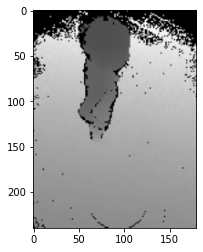

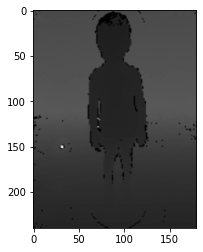

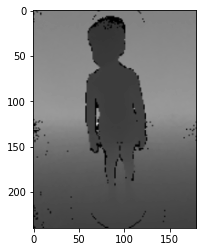

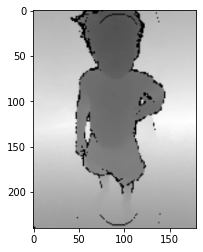

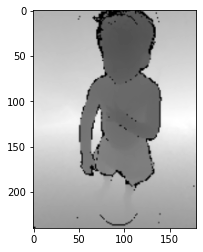

In [18]:
show_depthmaps(depthmaps)

### Prepare depthmap

In [19]:
#FROM CGM-RG

IMAGE_TARGET_HEIGHT = 240
IMAGE_TARGET_WIDTH = 180
NORMALIZATION_VALUE = 7.5

def preprocess_depthmap(depthmap):
    return depthmap.astype("float32")

def preprocess(depthmap):
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / NORMALIZATION_VALUE
    depthmap = resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    depthmap = depthmap.reshape((depthmap.shape[0], depthmap.shape[1], 1))
    return depthmap

In [20]:
preprocessed_depthmaps = []

for depthmap in depthmaps:
    preprocessed_depthmap = preprocess(depthmap)
    preprocessed_depthmap = np.expand_dims(preprocessed_depthmap, axis=0)
    preprocessed_depthmaps.append(preprocessed_depthmap)

print(type(preprocessed_depthmaps))
print(type(preprocessed_depthmaps[0].shape))
print(len(preprocessed_depthmaps))
#print(preprocessed_depthmaps[0])

<class 'list'>
<class 'tuple'>
5


# Create heatmap

In [21]:
# Remove last layer's softmax
height_model.layers[-1].activation = None

#make this a variable - how can I retrieve this from any model??
last_conv_layer_name = 'conv2d_11'
#iterate over layers names attribute and find the one with the biggest id - has conv in the name

In [22]:
heatmaps = make_gradcam_heatmaps(preprocessed_depthmaps, height_model, last_conv_layer_name)


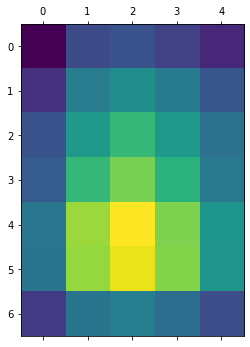

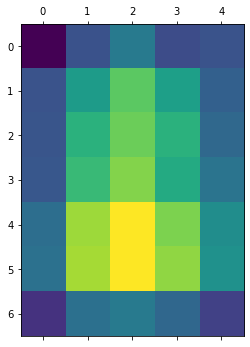

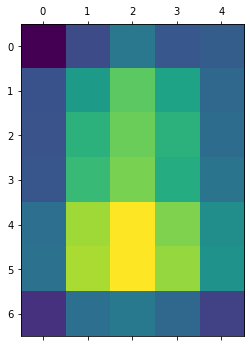

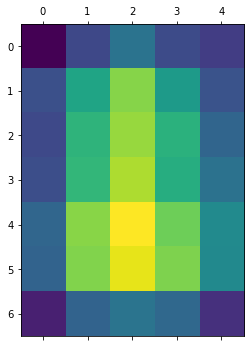

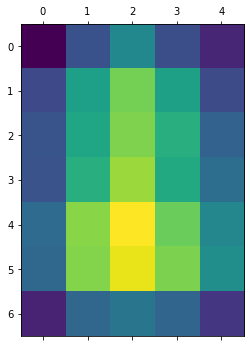

In [23]:
show_heatmaps(heatmaps)

In [ ]:
#depthmaps_no_batchdim = remove_batchdim(preprocessed_depthmaps)

In [ ]:
#print(depthmaps_no_batchdim[0].shape)
#print(len(depthmaps_no_batchdim))

In [ ]:
#superimposed_imgs = return_gradcams(depthmaps_no_batchdim, heatmaps, transparency=0.99)

In [ ]:
#show_gradcam(superimposed_imgs)

# CGM-RG: Height Flow - adapt inference.get_height_predictions_local

In [ ]:
#class HeightFlowPlainCnn(HeightFlow):
#    def run_flow(self):
#        depthmaps = preprocessing.process_depthmaps(self.artifacts, self.scan_directory, self.result_generation)
#        height_predictions = inference.get_height_predictions_local(depthmaps)
#        generated_timestamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')
#        self.post_height_results(height_predictions, generated_timestamp)

#def get_height_predictions_local(numpy_array):
#    return height_model.predict(numpy_array)

## HOW can I dynamically get the name of the last conv layer

# TODO: go back to one single depthmap - in cgm-rg one depthmap at a time is processed
# TODO: test own overlaying function

In [24]:
import cv2

def overlay_depthmap_gradcam(depthmap, gradcam, transparency=0.3):
    print(depthmap.shape)
    depthmap = depthmap.reshape(depthmap.shape[1:])
    print(depthmap.shape)
    depthmap_saved = keras.preprocessing.image.array_to_img(depthmap)
    depthmap_saved.save('depthmap.png')

    heatmap = np.uint8(255 * gradcam)
    print(heatmap.shape)

    jet_cm = cm.get_cmap("jet")
    jet_colors = jet_cm(np.arange(256))[:, :3] # THIS IS EXACTLY WHAT I WAS LOOKING FOR
    jet_heatmap = jet_colors[heatmap]
    print(jet_heatmap.shape)

    jet_hm_img = keras.preprocessing.image.array_to_img(jet_heatmap) # HIER FLIEGT rgb channel raus
    print(jet_hm_img.size)
    jet_hm_img = jet_hm_img.resize((depthmap.shape[1], depthmap.shape[0]))
    print(jet_hm_img.size)
    jet_hm_img.save('jetmap.png')
    
    
    depthmap_load = cv2.imread('depthmap.png')
    depthmap_load = depthmap_load[..., ::-1]

    jet_load = cv2.imread('jetmap.png')
    jet_load = jet_load[..., ::-1]
    output_image = cv2.addWeighted(depthmap_load, 0.6, jet_load, 0.4, 0)
    #cv2.imwrite('jasmintest.png', output_image)

    plt.imshow(output_image)
    plt.show()
    return output_image

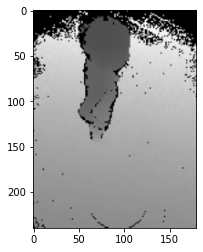

(1, 240, 180, 1)


In [25]:
depthmap_test = preprocessed_depthmaps[0]
show_depthmaps(depthmap_test)
print(depthmap_test.shape)

In [26]:
heatmap_test = heatmaps[0]
print(heatmap_test.shape)
print(type(heatmap_test))

(7, 5)
<class 'numpy.ndarray'>


(1, 240, 180, 1)
(240, 180, 1)
(7, 5)
(7, 5, 3)
(5, 7)
(180, 240)


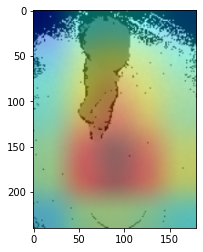

array([[[  0,  12, 102],
        [  0,  12, 102],
        [  0,  12, 102],
        ...,
        [  0,  55, 102],
        [  0,  55, 102],
        [  0,  55, 102]],

       [[  0,  12, 102],
        [  0,  12, 102],
        [  0,  12, 102],
        ...,
        [  0,  55, 102],
        [  0,  55, 102],
        [  0,  55, 102]],

       [[  0,  12, 102],
        [  0,  12, 102],
        [  0,  12, 102],
        ...,
        [  0,  56, 102],
        [  0,  56, 102],
        [  0,  56, 102]],

       ...,

       [[  0,  80, 102],
        [ 52, 132, 154],
        [ 82, 163, 184],
        ...,
        [ 85, 187, 185],
        [ 84, 186, 184],
        [ 83, 185, 184]],

       [[  0,  80, 102],
        [ 32, 112, 134],
        [ 62, 143, 164],
        ...,
        [ 85, 187, 185],
        [ 85, 187, 185],
        [ 85, 187, 185]],

       [[  0,  80, 102],
        [  0,  80, 102],
        [ 29, 110, 131],
        ...,
        [ 85, 187, 185],
        [ 85, 187, 186],
        [ 86, 188, 187]]

In [27]:
overlay_depthmap_gradcam(depthmap_test, heatmap_test)


# NIKHIL

## Test Nikhils Link - is this what you were looking for?

In [47]:
# from https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54

def compute_pred_and_heatmap(height_model, image):

    grad_model = Model(inputs=[height_model.inputs], 
                            outputs=[height_model.get_layer(last_conv_layer_name).output, height_model.output])

    with tf.GradientTape() as tape:
        image = tf.cast(image, tf.float32)
        (conv_outputs, predictions) = grad_model(np.array(image))
        print("pred.shape = ", predictions.shape)
        print(predictions)
        classIdx = np.argmax(predictions[0])
        loss = predictions[:, classIdx] 
    
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return_pred = loss  # this name from exmpl is confusing - is this right?

    return heatmap, return_pred

In [70]:
depthmap_test = preprocessed_depthmaps[1]

In [71]:
heatmap_res, heightpred_res = compute_pred_and_heatmap(height_model, depthmap_test)

pred.shape =  (1, 1)
tf.Tensor([[90.03042]], shape=(1, 1), dtype=float32)


In [72]:
print(heightpred_res)

tf.Tensor([90.03042], shape=(1,), dtype=float32)


(1, 240, 180, 1)
(240, 180, 1)
(180, 240)
(180, 240, 3)
(240, 180)
(180, 240)


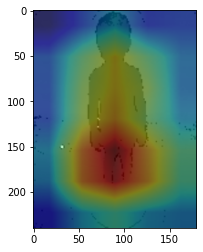

array([[[  0,   0,  51],
        [ 28,  28,  78],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 28,  28,  78],
        [ 38,  38,  89],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 44,  44,  95],
        [ 44,  44,  95],
        [ 44,  44,  95],
        ...,
        [ 34,  56, 136],
        [ 34,  57, 136],
        [ 44,  67, 146]],

       ...,

       [[  8,   8, 110],
        [ 17,  17, 118],
        [ 22,  22, 124],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  8,   8, 110],
        [ 17,  17, 118],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  0,   0, 102],
        [  8,   8, 110],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]]

In [73]:
overlay_depthmap_gradcam(depthmap_test, heatmap_res)

___________________________________________________________________

In [ ]:
""" def compute_pred_and_heatmap(height_model, image): - version P + online mixed

    grad_model = Model(inputs=[height_model.inputs], 
                            outputs=[height_model.get_layer(last_conv_layer_name).output, height_model.output])

    with tf.GradientTape() as tape:
        #tape.watch(grad_model.get_layer(last_conv_layer_name).output)
        inputs = tf.cast(image, tf.float32)
        (conv_outputs, predictions) = grad_model(inputs)
        print("pred.shape = ", predictions.shape)
        print(predictions)
        classIdx = np.argmax(predictions[0])

        if len(predictions)==1:
            loss = predictions[0]
        else:
            loss = predictions[:, classIdx] 
    
    grads = tape.gradient(loss, conv_outputs)
    
    return_pred = loss  # this name from exmpl is confusing - is this right?

    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads 

    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    heatmap = (heatmap * 255).astype("float32")
    return heatmap, return_pred """

## re-write get_height_predictions_local to get_height_prediction_and_heatmap_local

In [33]:
# 1. this is not efficient - do this in only one call like in example that nikhil showed us
# take a look at 1. (second iteration)
# 2. write a new output file wor gradcam - integrate in height flow (first iteration)

def get_height_pred_local_and_gradcam(numpy_array):
    height_prediction = height_model.predict(numpy_array)
    #do gradcam
    #note: load_model is called in cgm-rg - but I still had to do the compilation stuff "manually" to get gradcam work
    # Remove last layer's softmax
    height_model.layers[-1].activation = None 
    last_conv_layer_name = 'conv2d_11'  # How can I retrieve this for different models dynamically?
    #numpy_array = np.expand_dims(numpy_array, axis=0)
    print(numpy_array.shape)
    heatmap = make_gradcam_heatmaps(numpy_array, height_model, last_conv_layer_name)  # where do we put this function make_gradcam_heatmap
    #numpy_array_nobatch = remove_batchdim(preprocessed_depthmaps)
    #gradcam = return_gradcams(numpy_array_nobatch, heatmap, transparency=0.3)
    gradcam = overlay_depthmap_gradcam(numpy_array, heatmap)
    
    return height_prediction, gradcam

# TO DO HERE: do correct numpy_array preprocessing in this function!

In [34]:
height_pred, gradcam = get_height_pred_local_and_gradcam(depthmap_test[0])

ValueError: in user code:

    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/jasmin/.pyenv/versions/3.7.9/envs/py37-cgm/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 180, 1)
